# GNNs

## mass into account

In [31]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GeneralConv
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from datagen import generate_dataset, generate_dataset_nbodies
from tqdm import tqdm



def fully_connected(input_dim, hidden_dim, output_dim, num_layers):
    layers = []
    # Add hidden layers
    for _ in range(num_layers):
        layers.append(torch.nn.Linear(input_dim, hidden_dim))
        layers.append(torch.nn.ReLU())
        input_dim = hidden_dim
    # Add output layer
    layers.append(torch.nn.Linear(hidden_dim, output_dim))
    return torch.nn.Sequential(*layers)

# Function to create edge weights based on mass difference
def create_edge_attributes_based_on_mass_and_dist(data):
    row, col = data.edge_index  # Get indices of connected nodes
    # Get masses for each node in the connection
    pos_row = data.x[row][:, :3]
    pos_col = data.x[col][:, :3]
    distance = torch.norm(pos_row - pos_col, dim=1)  # Calculate distance between nodes
    mass_row = data.x[row][:, -1]
    mass_col = data.x[col][:, -1]
    mass_prod = mass_row * mass_col  # Multiply masses
    data.edge_attr = torch.stack([mass_prod, distance], dim=1)  # Concatenate edge attributes
    
    return data

class ParticleGNN(torch.nn.Module):
    def __init__(self, input_dim, fc_dim, fc_layers, gnn_dim, message_passing_steps, output_dim):
        super(ParticleGNN, self).__init__()
        # Encoder for initial node features
        self.encoder = fully_connected(input_dim, fc_dim, gnn_dim, fc_layers)
        
        # GeneralConv layers for message passing
        self.gnns = []
        for i in range(message_passing_steps):
            gnn = GeneralConv(in_channels=gnn_dim, out_channels=gnn_dim, aggr='add', directed_msg=False, in_edge_channels=2)
            setattr(self, f'gnn_{i}', gnn)
            self.gnns.append(gnn)
        
        # Decoder to transform final node features to output
        self.decoder = fully_connected(gnn_dim, fc_dim, output_dim, fc_layers)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr  # Use edge_attr instead of edge_weight
        x = self.encoder(x)
        
        for gnn in self.gnns:
            x = F.relu(gnn(x, edge_index, edge_attr=edge_attr))  # Pass edge_attr to GeneralConv
        
        x = self.decoder(x)
        return x



# Function to convert particles to a torch_geometric Data object
def transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius):
    # Extract features for each particle: [x, y, z, vx, vy, vz, mass]

    
    # Create edges based on radius
    edge_index = radius_graph(positions, r=radius)
    # for every node, connect it to top 2 biggest nodes
    '''
    biggest_nodes_index = torch.argsort(features[:, -1], descending=True)[:2]
    for i in range(features.shape[0]):
        if i not in biggest_nodes_index:
            edge_index = torch.cat((edge_index, torch.tensor([[i, biggest_nodes_index[0]], [i, biggest_nodes_index[1]]], dtype=torch.long)), 1)
            edge_index = torch.cat((edge_index, torch.tensor([[biggest_nodes_index[0], i], [biggest_nodes_index[1], i]], dtype=torch.long)), 1)
    '''


    
    # Create data object
    graph_data = Data(x=features, edge_index=edge_index)
    
    # Add edge weights based on mass
    graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
    return graph_data



  


In [32]:
def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b)**2, dim=-1) + 1e-12)
def mean_distance(a, b):
    return torch.mean(euclidean_distance(a, b))

In [33]:
import torch
def generate_graph_dataset(data, radius):
    graphs = []
    for i in tqdm(range(len(data))):
        masses = torch.tensor(data[i]['masses']).unsqueeze(-1)
        positions = torch.tensor(data[i]['pos'])
        velocities = torch.tensor(data[i]['vel'])
        Gs = torch.ones_like(masses) 
        softening = torch.ones_like(masses) * 0.1
        features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
        graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius)
        graph_data.y = torch.tensor(data[i]['acc'])
        graphs.append(graph_data)
    return graphs

In [39]:
# Initialize model and optimizer
import os
model = ParticleGNN(input_dim=9, fc_dim=128, fc_layers=1, gnn_dim=128, message_passing_steps=5, output_dim=3)
# load model weights
model.load_state_dict(torch.load('./models/'+sorted(os.listdir('models'), key=lambda x: int(x.split('.')[0].split('_')[-1]))[-1]))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [43]:

ROUNDS = 50
EPOCHS = 4
SCENES = 50
WINDOW_SIZE = 0
N_BODIES = 3
BATCH_SIZE = 16
RADIUS = 2.0


# Training loop
model.train()
for r in range(ROUNDS):
    print(f'--- Round {r} ---')
    data = generate_dataset_nbodies(n_scenes=SCENES, n_bodies=N_BODIES)
    print('Converting to graphs...')
    graphs = generate_graph_dataset(data, RADIUS)
    dataloader = DataLoader(graphs, batch_size=BATCH_SIZE)
    print('Training...')
    for epoch in range(EPOCHS):
        epoch_losses = []
        print(f'Epoch {epoch+1}')
        for data in tqdm(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = mean_distance(out, data.y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {torch.tensor(epoch_losses).mean()}')
    del data, graphs, dataloader
    torch.cuda.empty_cache()
    if (r+1) % 10 == 0:
        print('Saving model...')
        torch.save(model.state_dict(), f'./models/particle_gnn_{r}.pth')
    







--- Round 0 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 16.21it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4262.62it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 123.29it/s]


Epoch 1, Loss: 0.1632859855890274
Epoch 2


100%|██████████| 3125/3125 [00:47<00:00, 65.42it/s] 


Epoch 2, Loss: 0.14237433671951294
Epoch 3


100%|██████████| 3125/3125 [01:12<00:00, 43.14it/s]


Epoch 3, Loss: 0.13712972402572632
Epoch 4


100%|██████████| 3125/3125 [01:29<00:00, 34.88it/s]


Epoch 4, Loss: 0.13398423790931702
--- Round 1 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:44<00:00, 1135.55it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [01:18<00:00, 39.76it/s]


Epoch 1, Loss: 0.15480804443359375
Epoch 2


100%|██████████| 3125/3125 [00:58<00:00, 53.82it/s] 


Epoch 2, Loss: 0.14096948504447937
Epoch 3


100%|██████████| 3125/3125 [00:33<00:00, 93.52it/s] 


Epoch 3, Loss: 0.13361777365207672
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 123.67it/s]


Epoch 4, Loss: 0.13094070553779602
--- Round 2 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 19.19it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:10<00:00, 4624.14it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 125.93it/s]


Epoch 1, Loss: 0.14121496677398682
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 124.79it/s]


Epoch 2, Loss: 0.129038006067276
Epoch 3


100%|██████████| 3125/3125 [00:26<00:00, 116.60it/s]


Epoch 3, Loss: 0.1229531541466713
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 123.72it/s]


Epoch 4, Loss: 0.11909303814172745
--- Round 3 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.18it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:10<00:00, 4672.54it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 125.75it/s]


Epoch 1, Loss: 0.15791986882686615
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 127.56it/s]


Epoch 2, Loss: 0.138510599732399
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 128.67it/s]


Epoch 3, Loss: 0.13264143466949463
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 129.67it/s]


Epoch 4, Loss: 0.13014328479766846
--- Round 4 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 18.48it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:10<00:00, 4645.59it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 128.03it/s]


Epoch 1, Loss: 0.1507970541715622
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 127.96it/s]


Epoch 2, Loss: 0.1353781372308731
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 126.12it/s]


Epoch 3, Loss: 0.12928009033203125
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 125.07it/s]


Epoch 4, Loss: 0.12524107098579407
--- Round 5 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.40it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:10<00:00, 4574.87it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 128.32it/s]


Epoch 1, Loss: 0.1564934253692627
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 126.77it/s]


Epoch 2, Loss: 0.1370563954114914
Epoch 3


100%|██████████| 3125/3125 [00:23<00:00, 131.49it/s]


Epoch 3, Loss: 0.1325642317533493
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 122.59it/s]


Epoch 4, Loss: 0.1278264820575714
--- Round 6 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 16.52it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:10<00:00, 4546.25it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 127.51it/s]


Epoch 1, Loss: 0.22254785895347595
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 124.66it/s]


Epoch 2, Loss: 0.19462443888187408
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 122.60it/s]


Epoch 3, Loss: 0.18432632088661194
Epoch 4


100%|██████████| 3125/3125 [00:27<00:00, 112.14it/s]


Epoch 4, Loss: 0.1759158819913864
--- Round 7 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.39it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4441.69it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:26<00:00, 120.04it/s]


Epoch 1, Loss: 0.1355588138103485
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 121.88it/s]


Epoch 2, Loss: 0.1295333057641983
Epoch 3


100%|██████████| 3125/3125 [00:26<00:00, 120.04it/s]


Epoch 3, Loss: 0.12252063304185867
Epoch 4


100%|██████████| 3125/3125 [00:26<00:00, 118.03it/s]


Epoch 4, Loss: 0.1195460855960846
--- Round 8 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.60it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4503.12it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 124.02it/s]


Epoch 1, Loss: 0.1430407464504242
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 127.95it/s]


Epoch 2, Loss: 0.1261206865310669
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 126.63it/s]


Epoch 3, Loss: 0.12186115235090256
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 129.52it/s]


Epoch 4, Loss: 0.11808741092681885
--- Round 9 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 16.66it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:10<00:00, 4609.13it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 128.83it/s]


Epoch 1, Loss: 0.14049404859542847
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 126.92it/s]


Epoch 2, Loss: 0.124269500374794
Epoch 3


100%|██████████| 3125/3125 [00:26<00:00, 118.43it/s]


Epoch 3, Loss: 0.11777719855308533
Epoch 4


100%|██████████| 3125/3125 [00:26<00:00, 118.43it/s]


Epoch 4, Loss: 0.11305757611989975
Saving model...
--- Round 10 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.71it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4537.10it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 124.64it/s]


Epoch 1, Loss: 0.13360926508903503
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 124.51it/s]


Epoch 2, Loss: 0.11816199123859406
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 129.16it/s]


Epoch 3, Loss: 0.11405966430902481
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 120.30it/s]


Epoch 4, Loss: 0.108187735080719
--- Round 11 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.82it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4479.96it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:26<00:00, 117.12it/s]


Epoch 1, Loss: 0.17585456371307373
Epoch 2


100%|██████████| 3125/3125 [00:26<00:00, 118.47it/s]


Epoch 2, Loss: 0.15107092261314392
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 121.88it/s]


Epoch 3, Loss: 0.14331740140914917
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 126.66it/s]


Epoch 4, Loss: 0.13925214111804962
--- Round 12 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 16.44it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4431.08it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:35<00:00, 86.84it/s] 


Epoch 1, Loss: 0.13607676327228546
Epoch 2


100%|██████████| 3125/3125 [00:58<00:00, 53.00it/s]


Epoch 2, Loss: 0.1251855343580246
Epoch 3


100%|██████████| 3125/3125 [00:36<00:00, 85.98it/s] 


Epoch 3, Loss: 0.11962943524122238
Epoch 4


100%|██████████| 3125/3125 [00:33<00:00, 93.37it/s] 


Epoch 4, Loss: 0.11577987670898438
--- Round 13 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.89it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4455.46it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 125.03it/s]


Epoch 1, Loss: 0.1432345062494278
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 121.15it/s]


Epoch 2, Loss: 0.12960447371006012
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 122.44it/s]


Epoch 3, Loss: 0.12132364511489868
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 123.11it/s]


Epoch 4, Loss: 0.1187075600028038
--- Round 14 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4322.17it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:29<00:00, 104.77it/s]


Epoch 1, Loss: 0.16280098259449005
Epoch 2


100%|██████████| 3125/3125 [00:26<00:00, 117.53it/s]


Epoch 2, Loss: 0.14317506551742554
Epoch 3


100%|██████████| 3125/3125 [00:26<00:00, 120.00it/s]


Epoch 3, Loss: 0.13626672327518463
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 125.32it/s]


Epoch 4, Loss: 0.13205087184906006
--- Round 15 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.54it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:10<00:00, 4614.95it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 126.80it/s]


Epoch 1, Loss: 0.134773850440979
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 120.79it/s]


Epoch 2, Loss: 0.12241455167531967
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 124.49it/s]


Epoch 3, Loss: 0.1182425394654274
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 127.16it/s]


Epoch 4, Loss: 0.11374881118535995
--- Round 16 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.65it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4529.94it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:26<00:00, 115.89it/s]


Epoch 1, Loss: 0.14367344975471497
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 125.24it/s]


Epoch 2, Loss: 0.12573625147342682
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 125.61it/s]


Epoch 3, Loss: 0.11853872984647751
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 127.82it/s]


Epoch 4, Loss: 0.1147446557879448
--- Round 17 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.86it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4472.89it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 129.04it/s]


Epoch 1, Loss: 0.14009405672550201
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 125.30it/s]


Epoch 2, Loss: 0.12490928918123245
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 124.84it/s]


Epoch 3, Loss: 0.11715050041675568
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 126.91it/s]


Epoch 4, Loss: 0.11493033170700073
--- Round 18 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 18.03it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4478.75it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 123.84it/s]


Epoch 1, Loss: 0.1365663856267929
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 126.96it/s]


Epoch 2, Loss: 0.12152361124753952
Epoch 3


100%|██████████| 3125/3125 [00:27<00:00, 115.02it/s]


Epoch 3, Loss: 0.11423217505216599
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 120.79it/s]


Epoch 4, Loss: 0.11129431426525116
--- Round 19 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.68it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4527.41it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 124.50it/s]


Epoch 1, Loss: 0.1270540952682495
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 125.93it/s]


Epoch 2, Loss: 0.11313413083553314
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 126.93it/s]


Epoch 3, Loss: 0.10887159407138824
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 127.22it/s]


Epoch 4, Loss: 0.10330624133348465
Saving model...
--- Round 20 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 16.64it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4487.06it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 123.98it/s]


Epoch 1, Loss: 0.14476123452186584
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 128.02it/s]


Epoch 2, Loss: 0.12796005606651306
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 126.44it/s]


Epoch 3, Loss: 0.12080492079257965
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 125.04it/s]


Epoch 4, Loss: 0.11821039766073227
--- Round 21 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.85it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4499.86it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 127.22it/s]


Epoch 1, Loss: 0.13004453480243683
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 128.77it/s]


Epoch 2, Loss: 0.1156277060508728
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 125.25it/s]


Epoch 3, Loss: 0.10946988314390182
Epoch 4


100%|██████████| 3125/3125 [00:24<00:00, 127.72it/s]


Epoch 4, Loss: 0.10500457882881165
--- Round 22 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.92it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4427.52it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:23<00:00, 130.54it/s]


Epoch 1, Loss: 0.12694568932056427
Epoch 2


100%|██████████| 3125/3125 [00:24<00:00, 126.62it/s]


Epoch 2, Loss: 0.11338580399751663
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 126.00it/s]


Epoch 3, Loss: 0.10910005867481232
Epoch 4


100%|██████████| 3125/3125 [00:28<00:00, 111.35it/s]


Epoch 4, Loss: 0.10539901256561279
--- Round 23 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 19.68it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4532.95it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 124.49it/s]


Epoch 1, Loss: 0.12820738554000854
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 122.21it/s]


Epoch 2, Loss: 0.11300009489059448
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 121.37it/s]


Epoch 3, Loss: 0.10721635818481445
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 121.55it/s]


Epoch 4, Loss: 0.1028403490781784
--- Round 24 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 16.04it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4308.83it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 121.04it/s]


Epoch 1, Loss: 0.1364579051733017
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 121.57it/s]


Epoch 2, Loss: 0.12240881472826004
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 123.41it/s]


Epoch 3, Loss: 0.11504291743040085
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 122.64it/s]


Epoch 4, Loss: 0.1111576184630394
--- Round 25 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 16.81it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4345.87it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 122.21it/s]


Epoch 1, Loss: 0.14556998014450073
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 120.74it/s]


Epoch 2, Loss: 0.1284124255180359
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 123.19it/s]


Epoch 3, Loss: 0.12155816704034805
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 121.82it/s]


Epoch 4, Loss: 0.11705374717712402
--- Round 26 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.45it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4380.34it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:26<00:00, 119.91it/s]


Epoch 1, Loss: 0.13820412755012512
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 121.74it/s]


Epoch 2, Loss: 0.12186095863580704
Epoch 3


100%|██████████| 3125/3125 [00:26<00:00, 117.59it/s]


Epoch 3, Loss: 0.1174435243010521
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 120.99it/s]


Epoch 4, Loss: 0.11262816190719604
--- Round 27 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.25it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4386.26it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 122.16it/s]


Epoch 1, Loss: 0.11947625875473022
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 123.60it/s]


Epoch 2, Loss: 0.10774420946836472
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 121.26it/s]


Epoch 3, Loss: 0.10198298841714859
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 122.44it/s]


Epoch 4, Loss: 0.09917822480201721
--- Round 28 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.40it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4344.10it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 123.34it/s]


Epoch 1, Loss: 0.12920069694519043
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 122.36it/s]


Epoch 2, Loss: 0.11144624650478363
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 122.43it/s]


Epoch 3, Loss: 0.10775111615657806
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 122.19it/s]


Epoch 4, Loss: 0.10331130027770996
--- Round 29 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4358.73it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 121.53it/s]


Epoch 1, Loss: 0.1431962251663208
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 121.29it/s]


Epoch 2, Loss: 0.12463876605033875
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 120.64it/s]


Epoch 3, Loss: 0.11857952177524567
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 121.32it/s]


Epoch 4, Loss: 0.11387751251459122
Saving model...
--- Round 30 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.29it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4327.19it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 121.00it/s]


Epoch 1, Loss: 0.1212388351559639
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 121.08it/s]


Epoch 2, Loss: 0.10688720643520355
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 121.39it/s]


Epoch 3, Loss: 0.10302799195051193
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 121.28it/s]


Epoch 4, Loss: 0.09762390702962875
--- Round 31 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4315.83it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 120.73it/s]


Epoch 1, Loss: 0.1405811905860901
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 121.52it/s]


Epoch 2, Loss: 0.12404995411634445
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 121.93it/s]


Epoch 3, Loss: 0.11833596974611282
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 120.78it/s]


Epoch 4, Loss: 0.11459087580442429
--- Round 32 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 18.49it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4201.02it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:24<00:00, 128.92it/s]


Epoch 1, Loss: 0.10937891900539398
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 122.72it/s]


Epoch 2, Loss: 0.0997532457113266
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 124.04it/s]


Epoch 3, Loss: 0.0938025563955307
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 122.46it/s]


Epoch 4, Loss: 0.09188078343868256
--- Round 33 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 19.01it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4499.80it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 122.34it/s]


Epoch 1, Loss: 0.12767916917800903
Epoch 2


100%|██████████| 3125/3125 [00:26<00:00, 115.75it/s]


Epoch 2, Loss: 0.11099793016910553
Epoch 3


100%|██████████| 3125/3125 [01:19<00:00, 39.34it/s]


Epoch 3, Loss: 0.10594386607408524
Epoch 4


100%|██████████| 3125/3125 [01:26<00:00, 36.08it/s]


Epoch 4, Loss: 0.10143420100212097
--- Round 34 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:38<00:00, 1309.41it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [01:15<00:00, 41.61it/s]


Epoch 1, Loss: 0.125711128115654
Epoch 2


100%|██████████| 3125/3125 [01:28<00:00, 35.35it/s]


Epoch 2, Loss: 0.10941465944051743
Epoch 3


100%|██████████| 3125/3125 [00:48<00:00, 64.78it/s] 


Epoch 3, Loss: 0.10541630536317825
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 122.88it/s]


Epoch 4, Loss: 0.10035070031881332
--- Round 35 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.82it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4519.15it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 121.60it/s]


Epoch 1, Loss: 0.10245513916015625
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 122.50it/s]


Epoch 2, Loss: 0.09134058654308319
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 125.59it/s]


Epoch 3, Loss: 0.0868653804063797
Epoch 4


100%|██████████| 3125/3125 [00:26<00:00, 117.98it/s]


Epoch 4, Loss: 0.0834178701043129
--- Round 36 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.39it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4458.88it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 124.93it/s]


Epoch 1, Loss: 0.12958107888698578
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 123.05it/s]


Epoch 2, Loss: 0.11333457380533218
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 122.44it/s]


Epoch 3, Loss: 0.106511190533638
Epoch 4


100%|██████████| 3125/3125 [00:27<00:00, 112.20it/s]


Epoch 4, Loss: 0.10248997807502747
--- Round 37 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.65it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4457.19it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 122.33it/s]


Epoch 1, Loss: 0.10365017503499985
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 122.89it/s]


Epoch 2, Loss: 0.0928918719291687
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 121.55it/s]


Epoch 3, Loss: 0.08849193155765533
Epoch 4


100%|██████████| 3125/3125 [00:26<00:00, 119.38it/s]


Epoch 4, Loss: 0.08473176509141922
--- Round 38 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.33it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4280.70it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 122.14it/s]


Epoch 1, Loss: 0.12089452892541885
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 122.71it/s]


Epoch 2, Loss: 0.10475941747426987
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 124.37it/s]


Epoch 3, Loss: 0.09879831969738007
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 124.00it/s]


Epoch 4, Loss: 0.09503497928380966
--- Round 39 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 16.15it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4467.47it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 123.73it/s]


Epoch 1, Loss: 0.1102697104215622
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 124.67it/s]


Epoch 2, Loss: 0.09747964888811111
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 122.20it/s]


Epoch 3, Loss: 0.09221413731575012
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 123.24it/s]


Epoch 4, Loss: 0.08810003846883774
Saving model...
--- Round 40 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 19.62it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4376.09it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 123.00it/s]


Epoch 1, Loss: 0.11706876754760742
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 123.11it/s]


Epoch 2, Loss: 0.10192622989416122
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 123.26it/s]


Epoch 3, Loss: 0.09736157953739166
Epoch 4


100%|██████████| 3125/3125 [00:27<00:00, 115.38it/s]


Epoch 4, Loss: 0.09288202226161957
--- Round 41 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 19.52it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4515.23it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:26<00:00, 117.31it/s]


Epoch 1, Loss: 0.11508911848068237
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 122.62it/s]


Epoch 2, Loss: 0.10032761096954346
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 121.38it/s]


Epoch 3, Loss: 0.09553235024213791
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 122.59it/s]


Epoch 4, Loss: 0.09176987409591675
--- Round 42 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:03<00:00, 16.55it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:10<00:00, 4551.61it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 124.79it/s]


Epoch 1, Loss: 0.14468643069267273
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 120.43it/s]


Epoch 2, Loss: 0.12549738585948944
Epoch 3


100%|██████████| 3125/3125 [00:24<00:00, 125.79it/s]


Epoch 3, Loss: 0.11966933310031891
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 122.34it/s]


Epoch 4, Loss: 0.11525101214647293
--- Round 43 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.70it/s]


Converting to graphs...


100%|██████████| 50000/50000 [00:11<00:00, 4511.57it/s]


Training...
Epoch 1


100%|██████████| 3125/3125 [00:25<00:00, 120.60it/s]


Epoch 1, Loss: 0.1241213008761406
Epoch 2


100%|██████████| 3125/3125 [00:25<00:00, 122.60it/s]


Epoch 2, Loss: 0.111137755215168
Epoch 3


100%|██████████| 3125/3125 [00:25<00:00, 124.72it/s]


Epoch 3, Loss: 0.10444742441177368
Epoch 4


100%|██████████| 3125/3125 [00:25<00:00, 122.00it/s]


Epoch 4, Loss: 0.10246609151363373
--- Round 44 ---
Generating 3-body dataset with 50 scenes...


100%|██████████| 50/50 [00:02<00:00, 17.49it/s]


Converting to graphs...


 47%|████▋     | 23671/50000 [00:05<00:05, 4673.64it/s]


KeyboardInterrupt: 

In [78]:
from datagen import generate_n_body_scene
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# animate the scene in 3d comparing the predicted scene with the actual scene
def get_new_pos_vel(acc, pos, vel, dt=0.01):
    new_vel = vel + acc * dt
    new_pos = pos + new_vel * dt
    return new_pos, new_vel

def sim_accelerations(positions, masses, G=1.0, softening=0.1):
    x = positions[:, 0:1]
    y = positions[:, 1:2]
    z = positions[:, 2:3]
    
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0]**(-1.5)
    
    ax = G * (dx * inv_r3) @ masses
    ay = G * (dy * inv_r3) @ masses
    az = G * (dz * inv_r3) @ masses

    return np.hstack((ax, ay, az))

def generate_rollout(model, scene, n_steps=1000, dt=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            out = model(graph_data)
            acc = out.cpu().numpy()
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)

def generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=0.5):

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            if np.random.rand() < model_percentage:
                out = model(graph_data)
                acc = out.cpu().numpy()
            else:
                acc = sim_accelerations(positions.numpy(), masses.numpy())
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)


def animate_scene(scene, pos_pred):
    # create a 2 animation side by side, do in 3d    
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_zlim(-2, 2)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.set_title('Ground Truth')


    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_zlim(-2, 2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_title('Prediction')
    n_bodies = len(scene['masses'])
    gt_pos = np.array([frame['pos'] for frame in scene['frames']])
    scat1 = ax1.scatter(gt_pos[0, :, 0], gt_pos[0, :, 1], gt_pos[0, :, 2])

    scat2 = ax2.scatter(pos_pred[0, :, 0], pos_pred[0, :, 1], pos_pred[0, :, 2])

    def update(frame):
        scat1._offsets3d = (gt_pos[frame, :, 0], gt_pos[frame, :, 1], gt_pos[frame, :, 2])
        scat2._offsets3d = (pos_pred[frame, :, 0], pos_pred[frame, :, 1], pos_pred[frame, :, 2])
        return scat1, scat2
    
    mean_distance_per_step = []
    for i in range(len(pos_pred)):
        mean_distance_per_step.append(mean_distance(torch.tensor(pos_pred[i]), torch.tensor(gt_pos[i])).item())
    print(f'Mean distance in whole sim: {np.mean(mean_distance_per_step)}')

    anim = FuncAnimation(fig, update, frames=len(pos_pred), blit=True, interval=10)
    return anim, mean_distance_per_step



scene = generate_n_body_scene(n_bodies=100)
pos_pred, acc_pred = generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=1)
#ani, mean_dist = animate_scene(scene, pos_pred)
#HTML(ani.to_html5_video())

Time for 0.0: 2.4763295650482178
Time for 0.1111111111111111: 1.5337090492248535
Time for 0.2222222222222222: 1.6844489574432373
Time for 0.3333333333333333: 1.945866584777832
Time for 0.4444444444444444: 2.063365936279297
Time for 0.5555555555555556: 2.13446307182312
Time for 0.6666666666666666: 2.351677417755127
Time for 0.7777777777777777: 2.260148525238037
Time for 0.8888888888888888: 2.2282216548919678
Time for 1.0: 2.2226333618164062


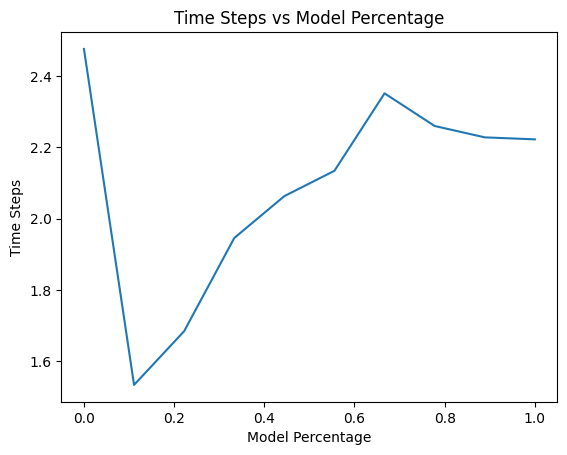

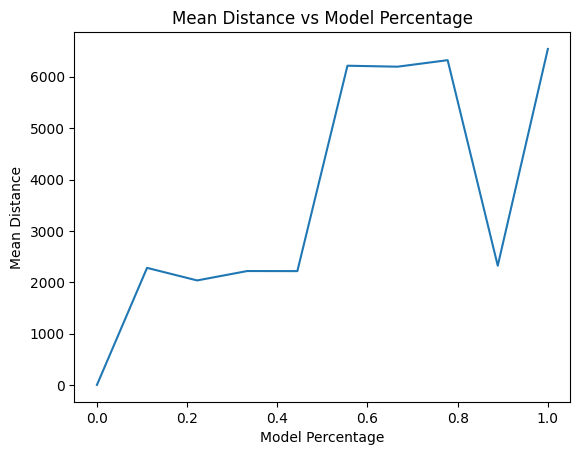

In [81]:
# from percentages from 0 to 1.0, plot the time it takes and the mean distance
import time

percentages = np.linspace(0, 1.0, 10)
times = []
mean_dists = []
gt_pos = np.array([frame['pos'] for frame in scene['frames']])

for p in percentages:
    start = time.time()
    pos_pred, acc_pred = generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=p)
    end = time.time()
    times.append(end-start)
    print(f'Time for {p}: {end-start}')
    mean_dist = []
    for i in range(len(pos_pred)):
        mean_dist.append(mean_distance(torch.tensor(pos_pred[i]), torch.tensor(gt_pos[i])).item())
    mean_dists.append(np.max(mean_dist))
plt.plot(percentages, times)
plt.xlabel('Model Percentage')
plt.ylabel('Time Steps')
plt.title('Time Steps vs Model Percentage')
plt.show()

plt.plot(percentages, mean_dists)
plt.xlabel('Model Percentage')
plt.ylabel('Mean Distance')
plt.title('Mean Distance vs Model Percentage')
plt.show()

